# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
import os 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
lsa_reports = "../../../reports/lsa/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

In [4]:
def load_sparse_dataframe(matrix_path,row_path,column_path,cols_str=True):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    if cols_str:
        col = np.loadtxt(column_path, dtype="str")
    else:
        col = np.loadtxt(column_path)
        
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

# Cargo archivos

In [15]:
#Analisis previos
infomap_clusters = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_clusters = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [ ]:
# Document-Term-Matrix  de clusters

path_infomap = data_processed + "tfidf_infomap/"
path_louvain = data_processed + "tfidf_louvain/"

monograms_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_0.npz",path_infomap + "rows_tfidf_infomap_0.txt", path_infomap+"cols_tfidf_infomap_0.txt")
monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")

bigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_1.npz",path_infomap + "rows_tfidf_infomap_1.txt", path_infomap+"cols_tfidf_infomap_1.txt")
bigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_1.npz",path_louvain + "rows_tfidf_louvain_1.txt", path_louvain+"cols_tfidf_louvain_1.txt")

trigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_2.npz",path_infomap + "rows_tfidf_infomap_2.txt", path_infomap+"cols_tfidf_infomap_2.txt")
trigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_2.npz",path_louvain + "rows_tfidf_louvain_2.txt", path_louvain+"cols_tfidf_louvain_2.txt")

infomap_dtm = [monograms_infomap, bigrams_infomap, trigrams_infomap]
louvain_dtm = [monograms_louvain, bigrams_louvain, trigrams_louvain]

In [5]:
# Document-Term-Matrix de nodos
path = data_processed + "tfidf_nodos/"
monograms_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
bigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_1.txt",path+"cols_tfidf_nodos_1.txt")
trigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_2.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_2.txt")

document_term_matrix = [monograms_dtm, bigrams_dtm, trigrams_dtm]

# Scree plot

### Nodos

In [6]:
X_nodos = monograms_dtm.sparse.to_dense()

svd = TruncatedSVD(n_components=1400)
lsa = svd.fit(X_nodos)

In [ ]:
y = lsa.explained_variance_ratio_
x = np.linspace(1,len(y),len(y))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,y,"o-")

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=2000)
ax.set_ylabel('Fracción de varianza acumulada - Nodos')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 80% de varianza acumlada con {corte} componentes")
# fig.savefig(lsa_reports+"evr_plot.png")

### Clusters

In [ ]:
X_infomap = infomap_dtm[0].sparse.to_dense()

svd_infomap = TruncatedSVD(n_components=1000)
lsa_infomap = svd_infomap.fit(X_infomap)

X_louvain = louvain_dtm[0].sparse.to_dense()

svd_louvain = TruncatedSVD(n_components=1000)
lsa_louvain = svd_louvain.fit(X_louvain)

In [ ]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa_infomap.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=1000)
ax.set_ylabel('Fracción de varianza acumulada - Clusters Infomap')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")
# fig.savefig(lsa_reports+"evr_plot.png")


# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = lsa_louvain.explained_variance_ratio_
cant_componentes = range(1, len(evr) + 1)

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

#Elijo un corte en 90% de varianza acumulada
corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
sns.set_theme()
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(cant_componentes, varianza_acumulada, "-o")
ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
ax.set_xlim(xmin=-100, xmax=1000)
ax.set_ylabel('Fracción de varianza acumulada - Clusters Louvain')
ax.set_xlabel('Componentes')
ax.set_title("Varianza acumlada vs número de componentes - SVD")
print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")

In [ ]:
corte_infomap = 477
corte_louvain = 154

# Armo el modelo

### Clusters

In [ ]:
svd_infomap = TruncatedSVD(n_components=corte_infomap)
lsa_infomap = svd_infomap.fit(X_infomap)
lsa_infomap_data = lsa_infomap.transform(X_infomap)

svd_louvain = TruncatedSVD(n_components=corte_louvain)
lsa_louvain = svd_louvain.fit(X_louvain)
lsa_louvain_data = lsa_louvain.transform(X_louvain)

In [ ]:
# most important words for each topic
vocab_louvain = X_louvain.columns.values
component_data = {}

for i, comp in enumerate(lsa_louvain.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_louvain, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_louvain = pd.DataFrame.from_dict(component_data,orient="index")

In [ ]:
# most important words for each topic
vocab_infomap = X_infomap.columns.values
component_data = {}

for i, comp in enumerate(lsa_infomap.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_infomap, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_infomap = pd.DataFrame.from_dict(component_data,orient="index")

### Nodos

In [6]:
# component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
# lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [6]:
X_nodos = monograms_dtm.sparse.to_dense()

svd = TruncatedSVD(n_components=1400)
lsa_data = svd.fit_transform(X_nodos)

# lsa_data = lsa.transform(X_nodos)

In [8]:
# most important words for each topic
vocab = X_nodos.columns.values
component_data = {}

for i, comp in enumerate(svd.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab = pd.DataFrame.from_dict(component_data,orient="index")

Guardo matrices para no tener que volver a calcularlas

In [14]:
# component_vocab.to_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [15]:
sorted(zip(vocab,svd.components_[5]), key= lambda x:x[1], reverse=True)[:10]

[('spastic', 0.21968514253052357),
 ('hmsn', 0.21523630103557023),
 ('paraplegia', 0.1921745320743921),
 ('neuropathy', 0.18458628489376966),
 ('sensory', 0.17380946668632322),
 ('nerve', 0.15861468010214216),
 ('hereditary', 0.15518732194594498),
 ('motor', 0.1488971970240868),
 ('charcot', 0.13594197414165357),
 ('marie', 0.13576283858995947)]

In [ ]:
component_vocab

### Obtengo la matriz de similaridad

In [ ]:
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [18]:
# Esta linea solo si cargué los datos como matriz sparse
# lsa_data_dense = lsa_data.toarray()


lsa_similarity_matrix = cosine_similarity(lsa_data,lsa_data)

Convierto a sparse y guardo

In [19]:
# lsa_similarity_matrix_sparse = sparse.csr_matrix(lsa_similarity_matrix)
# sparse.save_npz(lsa_reports+"lsa_similarity_matrix.npz",lsa_similarity_matrix_sparse)

## Checkpoint

In [5]:
component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [6]:
from wordcloud import WordCloud

def plot_component_vocab(component,component_vocab):
    n = component
    fig,ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=component_vocab.loc[n,"wordlist"], y=component_vocab.loc[n,"scorelist"], ax=ax)
    ax.set_title(f"Top 10 términos de la componente {n}")
    plt.xticks(rotation=45)
    plt.tight_layout()

def wordcloud_component_vocab(component,component_vocab):
    n = component
    words = component_vocab.loc[n,"wordlist"]
    scores = component_vocab.loc[n,"scorelist"]
    wordcloud_dict = {word:score for (word,score) in zip(words,scores)}
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

In [21]:
component_vocab_infomap

NameError: name 'component_vocab_infomap' is not defined

In [ ]:
component_vocab_louvain

In [ ]:
wordcloud_component_vocab(8,component_vocab_louvain)

In [ ]:
plot_component_vocab(8,component_vocab_louvain)

In [ ]:
lsa_infomap_df = pd.DataFrame(lsa_infomap_data, index=X_infomap.index.values)
lsa_louvain_df = pd.DataFrame(lsa_louvain_data, index=X_louvain.index.values)

In [ ]:
random_cluster = np.random.choice(X_infomap.index.values,1)[0]
top_component = lsa_infomap_df.loc[random_cluster].idxmax()

plot_component_vocab(top_component,component_vocab_infomap)
wordcloud_component_vocab(top_component,component_vocab_infomap)
disease_attributes[disease_attributes.comunidades_infomap == random_cluster]

array(['CHARCOT-MARIE-TOOTH DISEASE, AXONAL, TYPE 2O',
       'Any Charcot-Marie-Tooth disease in which the cause of the disease is a mutation in the DYNC1H1 gene.',
       'A group of slowly progressive inherited disorders affecting motor and sensory peripheral nerves. Subtypes include HMSNs i-vii. hmsn I and ii both refer to charcot-marie-tooth disease. hmsn iii refers to hypertrophic neuropathy of infancy. hmsn iv refers to refsum disease. hmsn V refers to a condition marked by a hereditary motor and sensory neuropathy associated with spastic paraplegia hmsn vi refers to hmsn associated with an inherited optic atrophy , and hmsn vii refers to hmsn associated with retinitis pigmentosa.  group of peripheral nervous system hereditary disorders with varying course, symptoms, neuropathology, and genetics, but generally involving gradual loss of nerve conduction, distal wasting, deformity, and disability.',
       'A rare, genetic, subtype of autosomal dominant Charcot-Marie-Tooth disease

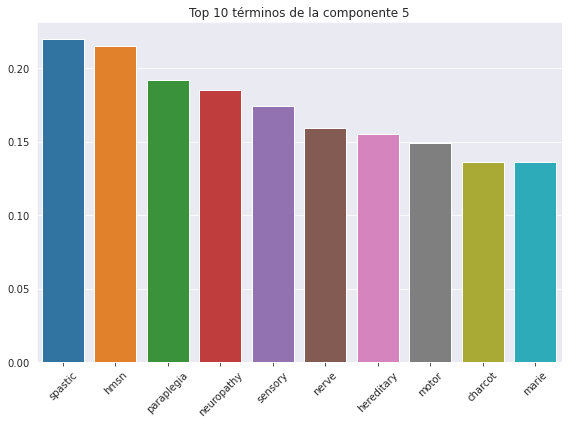

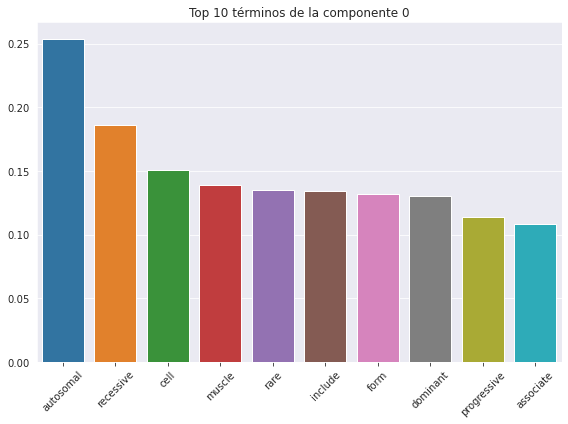

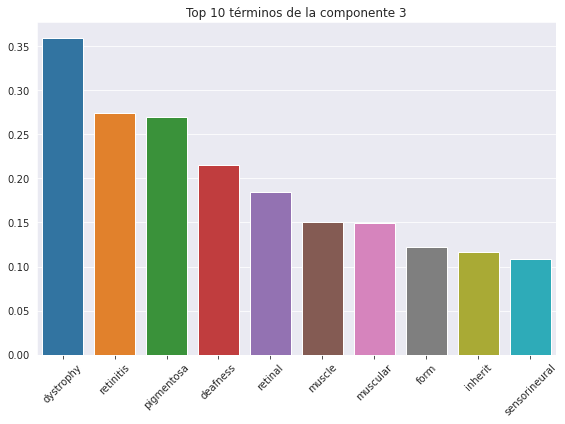

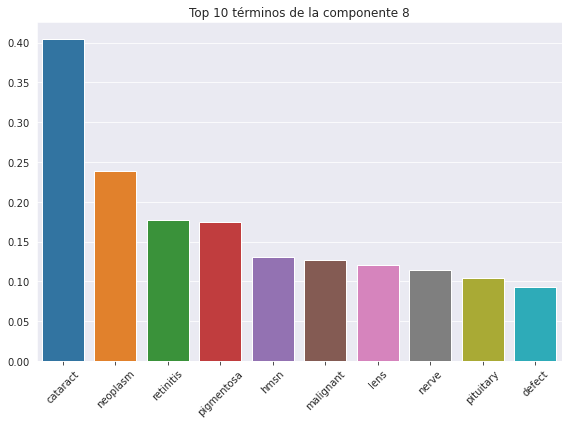

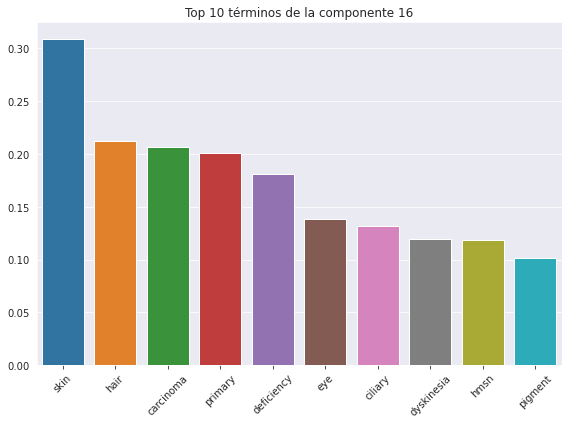

In [23]:
nodo = np.random.choice(range(lsa_data.shape[0]),1)[0]
vector_lsa = lsa_data[nodo]
top_10_components_idx = np.argsort(-vector_lsa)[0:10]
top_10_components_score = vector_lsa[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:5]:
    plot_component_vocab(component, component_vocab)

# Vuelvo a ver similaridad

In [7]:
def mean_similarity(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
    return round(np.mean(cluster_matrix.values), 2)

def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = disease_attributes[disease_attributes[algoritmo] == cluster].node_index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)
    
def get_similarity(document_term_matrix,df=True):
    ids = document_term_matrix.index.values
    scores = sparse.csr_matrix(document_term_matrix.values)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

In [8]:
ids = disease_attributes.node_index.values
lsa_similarity_matrix_df = pd.DataFrame.sparse.from_spmatrix(lsa_similarity_matrix, index=ids, columns=ids)

In [16]:
infomap_similarity = pd.Series({cluster:mean_similarity_triu(lsa_similarity_matrix_df, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="mean_similarity_lsa")
louvain_similarity = pd.Series({cluster:mean_similarity_triu(lsa_similarity_matrix_df, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="mean_similarity_lsa")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

Text(0.5, 1.0, 'Louvain')

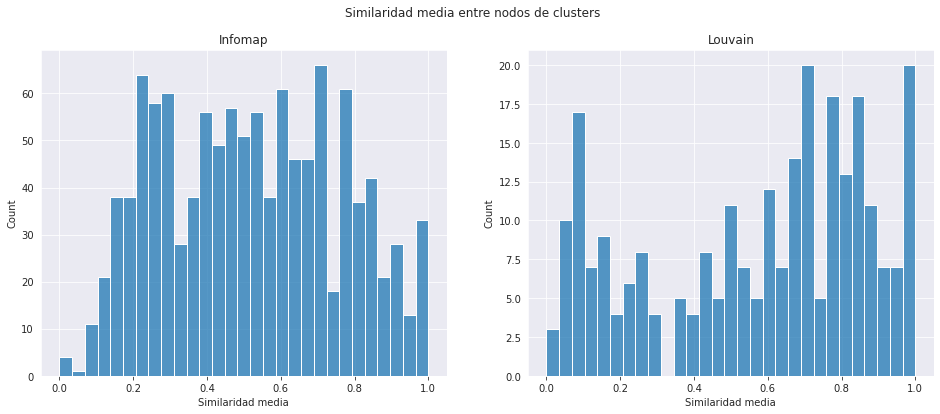

In [26]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Similaridad media entre nodos de clusters")
# ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=infomap_clusters,x="mean_similarity_lsa", ax=ax[0], bins=np.linspace(0,1,30))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters,x="mean_similarity_lsa", ax=ax[1], bins=np.linspace(0,1,30))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

In [38]:
aver = infomap_clusters[["comunidad","tamaño","mean_similarity_mono","mean_similarity_lsa"]]
aver[aver.mean_similarity_mono > aver.mean_similarity_lsa]

,comunidad,tamaño,mean_similarity_mono,mean_similarity_lsa
51,206,28,0.09,0.08
58,49,27,0.13,0.12
68,351,26,0.12,0.11
72,491,25,0.22,0.21
78,160,24,0.13,0.11
...,...,...,...,...
1136,968,2,0.88,0.86
1137,1060,2,0.67,0.43
1138,1010,2,0.62,0.11
1139,1121,2,0.62,0.27


In [29]:
# similaridad_todos = lsa_similarity_matrix.toarray()
# similaridad_todos_indices = np.triu_indices_from(similaridad_todos,1)
# similaridad_todos_values = similaridad_todos[similaridad_todos_indices]

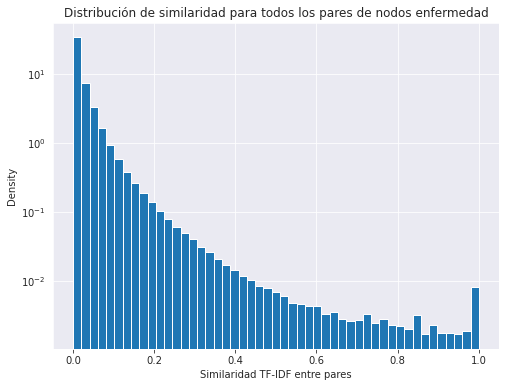

In [31]:
# plt.figure(figsize=(8,6))
# plot = plt.hist(similaridad_todos_values,bins=np.linspace(0,1,50),log=True, density=True)
# plt.title("Distribución de similaridad para todos los pares de nodos enfermedad")
# plt.xlabel("Similaridad TF-IDF entre pares")
# plt.ylabel("Density")
# plt.savefig(lsa_reports+"similaridad_todos.png",dpi=200)